In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='v910q8dG8mT8WOHROm4F_7VBERn88I4fXK81VRm3m1Na',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'improvedsourceofdrinkingwater-donotdelete-pr-drpy6spwgta0my'
object_key = 'nss Items data.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df_1.head(10)


,State,Age Group,Sector,Gender,Indicator,Value
0,All India,15 years and above,All,Male,Percentage of Persons Who Used Mobile Telephon...,83.2
1,All India,15 years and above,All,Female,Percentage of Persons Who Used Mobile Telephon...,56.7
2,All India,15 years and above,All,Person,Percentage of Persons Who Used Mobile Telephon...,70.2
3,All India,15 years and above,Rural,Male,Percentage of Persons Who Used Mobile Telephon...,80.2
4,All India,15 years and above,Rural,Female,Percentage of Persons Who Used Mobile Telephon...,49.9
5,All India,15 years and above,Rural,Person,Percentage of Persons Who Used Mobile Telephon...,65.3
6,All India,15 years and above,Urban,Male,Percentage of Persons Who Used Mobile Telephon...,90.0
7,All India,15 years and above,Urban,Female,Percentage of Persons Who Used Mobile Telephon...,72.4
8,All India,15 years and above,Urban,Person,Percentage of Persons Who Used Mobile Telephon...,81.4
9,All India,18 years and above,All,Male,Percentage of Persons Who Used Mobile Telephon...,86.6


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [3]:
# 1. EDA and Data Cleaning
print("Initial Data Overview:")
print(f"Shape: {df.shape}")
print(f"Missing Values:\n{df.isnull().sum()}")
print(f"\nData Types:\n{df.dtypes}")


Initial Data Overview:
Shape: (666, 6)
Missing Values:
State        0
Age Group    0
Sector       0
Gender       0
Indicator    0
Value        0
dtype: int64

Data Types:
State         object
Age Group     object
Sector        object
Gender        object
Indicator     object
Value        float64
dtype: object


In [4]:
# Clean state names
df['State'] = df['State'].str.replace('&', 'and').str.strip()

In [5]:
# Check for duplicates
print(f"\nDuplicate Rows: {df.duplicated().sum()}")


Duplicate Rows: 0


In [8]:
# 2. Data Visualization
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Mobile Access by Gender')

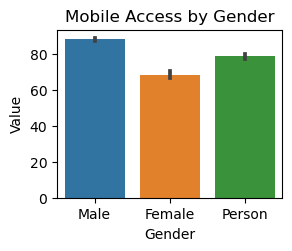

In [9]:
# Plot 1: Mobile access by gender
plt.subplot(2, 2, 1)
sns.barplot(x='Gender', y='Value', data=df)
plt.title('Mobile Access by Gender')

Text(0.5, 1.0, 'Rural vs Urban Mobile Access')

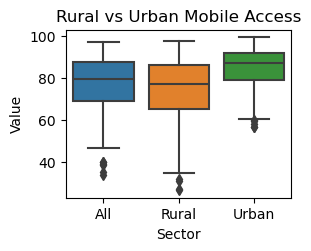

In [10]:
# Plot 2: Rural vs Urban comparison
plt.subplot(2, 2, 2)
sns.boxplot(x='Sector', y='Value', data=df)
plt.title('Rural vs Urban Mobile Access')

Text(0.5, 0, 'Percentage')

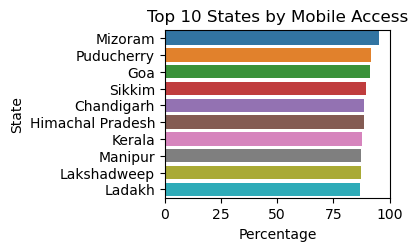

In [11]:
# Plot 3: Top 10 states by access
plt.subplot(2, 2, 3)
top_states = df.groupby('State')['Value'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_states.values, y=top_states.index)
plt.title('Top 10 States by Mobile Access')
plt.xlabel('Percentage')

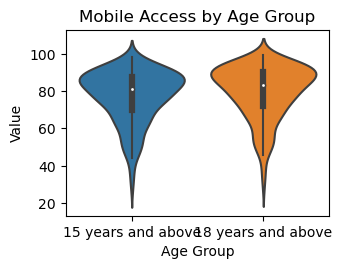

In [12]:

# Plot 4: Age group comparison
plt.subplot(2, 2, 4)
sns.violinplot(x='Age Group', y='Value', data=df)
plt.title('Mobile Access by Age Group')
plt.tight_layout()
plt.show()


In [13]:
# 3. Feature Engineering
# Encode categorical features
label_encoders = {}
for column in ['State', 'Sector', 'Gender']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [14]:
# Map age groups
df['Age Group'] = df['Age Group'].map({'15 years and above': 0, '18 years and above': 1})

In [15]:
# 4. Prepare Data for Modeling
X = df[['State', 'Age Group', 'Sector', 'Gender']]
y = df['Value']

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
# 5. Build ML Pipeline
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['State', 'Age Group', 'Sector', 'Gender'])
    ])

In [18]:
# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        random_state=42
    ))
])

In [19]:
# Train model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['State', 'Age Group',
                                                   'Sector', 'Gender'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=8, min_samples_split=5,
                                       n_estimators=200, random_state=42))])

In [20]:
# 6. Evaluate Model
predictions = model.predict(X_test)

In [21]:
print("\nModel Evaluation Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}")
print(f"R-squared: {r2_score(y_test, predictions):.2f}")


Model Evaluation Metrics:
RMSE: 8.02
R-squared: 0.72


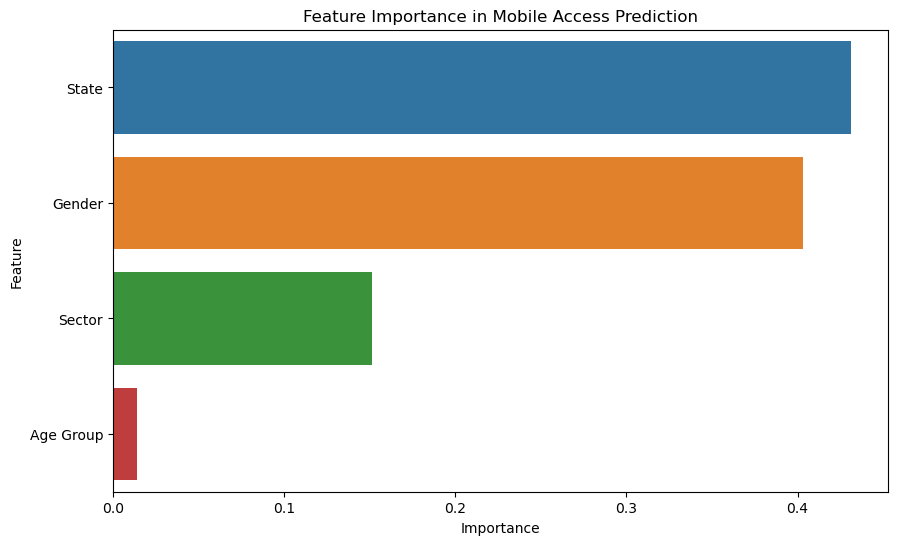

In [22]:
 #Feature Importance
feature_importances = model.named_steps['regressor'].feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Mobile Access Prediction')
plt.show()

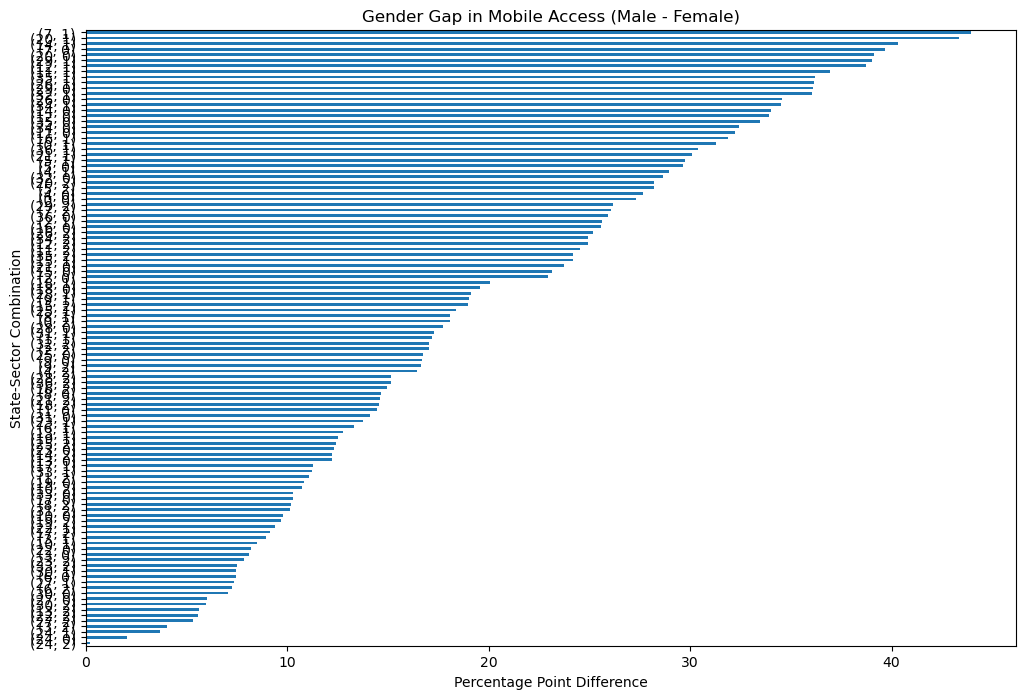

In [23]:
# 7. Additional Analysis: Gender Gap
df['Gender_Original'] = label_encoders['Gender'].inverse_transform(df['Gender'])
gender_gap = df.pivot_table(
    index=['State', 'Sector'],
    columns='Gender_Original',
    values='Value',
    aggfunc='mean'
)
gender_gap['Gender_Gap'] = gender_gap['Male'] - gender_gap['Female']

plt.figure(figsize=(12, 8))
gender_gap['Gender_Gap'].sort_values().plot(kind='barh')
plt.title('Gender Gap in Mobile Access (Male - Female)')
plt.xlabel('Percentage Point Difference')
plt.ylabel('State-Sector Combination')
plt.show()